In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import Config

In [2]:
res = 4096 # Resolution of the heal pixels
numBins = 10 # Number of bins to use
perVar = 0.98 # Percent of the variance to be captured
perMap = 0.25 # Percent of the PC maps to use, adjust this later

# Figuring Out Which Tile to Test

In [3]:
realFile1 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0129-5248.fits'
realFile2 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0245-0207.fits' # DON'T USE
realFile3 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0350-2415.fits' # DON'T USE
realFile4 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES0457-3206.fits' # DON'T USE
realFile5 = '/hdfs/bechtol/balrog/y3/y3_gold_2_2_DES2259+0001.fits' # DON'T USE

In [4]:
realData = fitsio.read(realFile1, columns = ['RA', 'DEC', 'FLAGS_FOREGROUND', 'FLAGS_BADREGIONS', 
                                            'FLAGS_FOOTPRINT', 'EXTENDED_CLASS_SOF'])

In [5]:
# These are in degrees which is why lonlat is set to True in the next cell.
realRA = realData['RA']
realDEC = realData['DEC']
# Everything from here on out is simply used in order to filter the data
FOREGROUND = realData['FLAGS_FOREGROUND']
BADREGIONS = realData['FLAGS_BADREGIONS']
FOOTPRINT = realData['FLAGS_FOOTPRINT']
CLASS = realData['EXTENDED_CLASS_SOF']

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (CLASS <= 1) & 
                      (CLASS >= 0))[0]

# This reduced the data down to the actually valid pixels.
realRA = realRA[cutIndices]
realDEC = realDEC[cutIndices]
realDET = np.ones(len(realDEC))

realPIX = hp.ang2pix(res, realRA, realDEC, lonlat = True, nest = True)

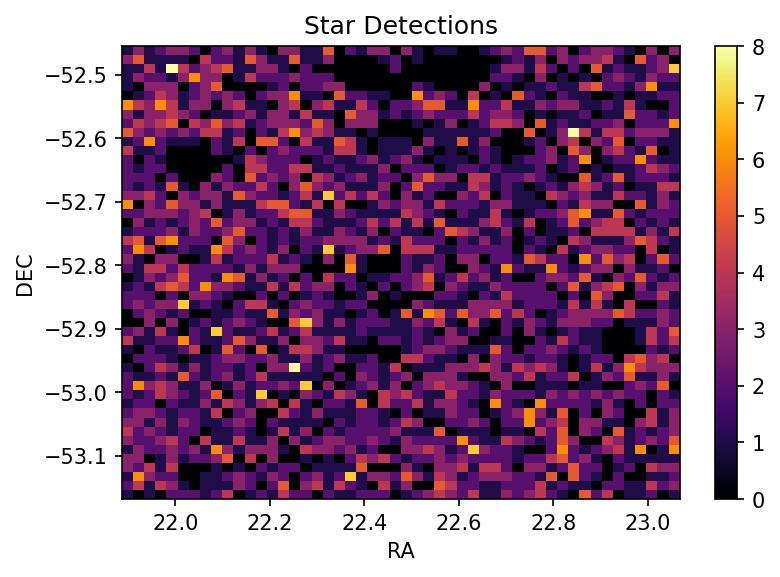

In [6]:
plt.figure(dpi = 150)
plt.hist2d(realRA, realDEC, weights = realDET, bins = 50, cmap = 'inferno')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Star Detections')
plt.colorbar()
plt.show()

# Actual Process

In [7]:
# This is the actual file containing all of the data
balrFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are detected, true_ra and true_dec which get used to convert into healPixels.
balrData = fitsio.read(balrFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'match_flag_1.5_asec'])

In [8]:
# These are in degrees which is why lonlat is set to True in the next cell.
balrRA = balrData['true_ra']
balrDEC = balrData['true_dec']
# This is used for detection rates, each point is either a 0 (no detection) or a 1 (detection)
balrDETRepeats = balrData['detected']
# Everything from here on out is simply used in order to filter the data
FOREGROUND = balrData['flags_foreground']
BADREGIONS = balrData['flags_badregions']
FOOTPRINT = balrData['flags_footprint']
ARCSECONDS = balrData['match_flag_1.5_asec']

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2))[0]

# This reduced the data down to the actually valid pixels.
balrDETRepeats = balrDETRepeats[cutIndices]
balrRA = balrRA[cutIndices]
balrDEC = balrDEC[cutIndices]

# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
balrPIXRepeats = hp.ang2pix(res, balrRA, balrDEC, lonlat = True, nest = True)

# This sorts by the pixel in order to make following methods more efficient.
sortInds = balrPIXRepeats.argsort()
balrPIXRepeats = balrPIXRepeats[sortInds[::1]]
balrDETRepeats = balrDETRepeats[sortInds[::1]]

# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
balrInd = 0

# This will be used to store the number of stars at each pixel.
balrPIX = np.unique(balrPIXRepeats) # The unique pixels, with no repeats.
balrDET = np.zeros_like(balrPIX)
balrINJ = np.zeros_like(balrPIX)

while balrInd < len(balrPIXRepeats):
    if balrPIX[uniqInd] == balrPIXRepeats[balrInd]: # If the pixels match up in the arrays.
        balrDET[uniqInd] += balrDETRepeats[balrInd]     # Add one if there was a detection at this location.
        balrINJ[uniqInd] += 1                # Add one to the corresponding spot in the balStar array.
        balrInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
        
# This loads in all of the file names of the survey conditions
condFiles = Config.files
balrCondMapsExt = []
realCondMapsExt = []

# This loops over every condition file except for stellar density which has a different format
for i in range(len(condFiles) - 1):
    condData = fitsio.read(condFiles[i]) # This reads in the data
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals
    condSigExt[np.where(condSigExt == -1.6375e+30)[0]] = hp.UNSEEN # Masks all non valid pixels
    if res != 4096:
        condSigExt=hp.ud_grade(condSigExt, res) # Only degrades if necessary (this is very time consuming)
    balrCondMapsExt.append(condSigExt[balrPIX]) # Only stores the values that are in pixels with injections
    realCondMapsExt.append(condSigExt[realPIX])
    
    
stelDensExt = fitsio.read(condFiles[-1])['I'].flatten() # Loads in the stellar density
stelDensExt[np.where(stelDensExt < 0)[0]] = hp.UNSEEN # Masks all non valid pixels
if res != 4096:
    stelDensExt=hp.ud_grade(stelDensExt, res) # Degrades if necessary
balrCondMapsExt.append(stelDensExt[balrPIX])
realCondMapsExt.append(stelDensExt[realPIX])

balrCondMapsExt = np.array(balrCondMapsExt, dtype = object) # Converts to an array
realCondMapsExt = np.array(realCondMapsExt, dtype = object) # Converts to an array

validIndices = np.full(len(balrPIX), True, dtype = bool)
# The only valid indices are ones where every survey property is unmasked
for cond in balrCondMapsExt:
    tempValidIndices = np.full(len(balrPIX), True, dtype = bool)
    tempValidIndices[np.where(cond < -1000000000)[0]] = False
    validIndices = validIndices & tempValidIndices
    
balrCondMaps = []
# Degrades all of the values to a common set of pixels
balrPIX = balrPIX[validIndices]
balrDET = balrDET[validIndices]
balrINJ = balrINJ[validIndices]

for cond in balrCondMapsExt:
    balrCondMaps.append(cond[validIndices])
    
balrCondMaps = np.array(balrCondMaps)

validIndices = np.full(len(realPIX), True, dtype = bool)
# The only valid indices are ones where every survey property is unmasked
for cond in realCondMapsExt:
    tempValidIndices = np.full(len(realPIX), True, dtype = bool)
    tempValidIndices[np.where(cond < -1000000000)[0]] = False
    validIndices = validIndices & tempValidIndices
    
realCondMaps = []
# Degrades all of the values to a common set of pixels
realPIX = realPIX[validIndices]
realDET = realDET[validIndices]
realRA = realRA[validIndices]
realDEC = realDEC[validIndices]

for cond in realCondMapsExt:
    realCondMaps.append(cond[validIndices])
    
realCondMaps = np.array(realCondMaps)

# Stores the original data for later comparisons
originalBalrDET = balrDET
originalBalrINJ = balrINJ
aveEff = np.sum(originalBalrDET) / np.sum(originalBalrINJ)

In [10]:
balrStanMaps = []
realStanMaps = []
# This standardizes every map as a first step of PCA
for i in range(len(balrCondMaps)):
    balrStanMaps.append((balrCondMaps[i] - np.average(balrCondMaps[i])) / np.std(balrCondMaps[i]))
    realStanMaps.append((realCondMaps[i] - np.average(balrCondMaps[i])) / np.std(balrCondMaps[i]))
    
    
balrStanMaps = np.array(balrStanMaps)
realStanMaps = np.array(realStanMaps)

In [11]:
# This gives the covariance matrix of the standardized maps
# Bias is true since the variance of each individual standardized map should be 1
cov = np.cov(balrStanMaps.astype(float), bias = True)

# This gives the eigenvalues and vectors of the covariance matrix
evalues, evectors = np.linalg.eig(cov)

# This cuts after the specified percentage of the variance has been achieved
for i in range(len(evalues)):
    if np.sum(evalues[0:i+1]) / np.sum(evalues) >= perVar:
        cutoff = i + 1
        break
featVec = evectors[0:cutoff]

In [12]:
balrRedMaps = np.matmul(featVec, balrStanMaps) # Reduces the maps to PCA maps
realRedMaps = np.matmul(featVec, realStanMaps) # Reduces the maps to PCA maps

In [13]:
# Goal of this method is to find the index of the map that has the largest impact on detection rates.
def mostSigPCMap(redMaps, balrDET, balrINJ = balrINJ, numBins = numBins):
    
    maxAdjustment = []

    for i in range(len(redMaps)):
        
        onePC = redMaps[i] # Load up a PC map

        binIndLims = [0]

        for j in range(numBins):
            binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

        # Sort detections and injections by the PC map value.
        sortInds = onePC.argsort()
        balrDETTemp = balrDET[sortInds[::1]]
        balrINJTemp = balrINJ[sortInds[::1]]

        detBins = []
        injBins = []

        # Bin up these detections and injections.
        for j in range(numBins):
            detBins.append(balrDETTemp[binIndLims[j]:binIndLims[j+1]])
            injBins.append(balrINJTemp[binIndLims[j]:binIndLims[j+1]])

        yValues = []

        # For each bin find the detection rate relative to the average.
        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        # Make the error the sum of the squared difference between the binned values and 1.
        maxAdjustment.append(np.max(np.abs(yValues - 1)))
        
    maxAdjustment = np.array(maxAdjustment)
    
    mostSigIndex = np.where(maxAdjustment == np.max(maxAdjustment))[0]
    
    return mostSigIndex[0] # Return wherever the error is the largest

In [14]:
# Goal is to find the best degree for fitting the data between one and five.
def findBestDegree(index, redMaps, balrDET, balrINJ = balrINJ, numBins = numBins):
    
    onePC = redMaps[index] # Load up a PC map
    
    # Gives the errors at each fit
    errors = []
    
    for potDegrees in (np.arange(5) + 1): # Potential degrees between 1 and 5
        
        balrDETTemp = np.copy(balrDET)
        
        fitParams = getFitParams(index, redMaps, potDegrees, balrDET)
        
        correction = np.full(len(balrDET), 0.0)
            
        for i in range(len(fitParams)):
            correction = correction + (fitParams[i] * (redMaps[index]**(len(fitParams) - 1 - i)))
                
        correction = 1 / correction
        
        balrDETTemp = balrDETTemp * correction # Apply the correction at the certain degree
        
        onePC = redMaps[index]
    
        binIndLims = [0]

        for j in range(numBins):
            binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

        sortInds = onePC.argsort()
        balrDETTemp = balrDETTemp[sortInds[::1]]
        balrINJTemp = balrINJ[sortInds[::1]]

        detBins = []
        injBins = []

        for j in range(numBins):
            detBins.append(balrDETTemp[binIndLims[j]:binIndLims[j+1]])
            injBins.append(balrINJTemp[binIndLims[j]:binIndLims[j+1]])

        yValues = []

        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        errors.append(np.max(np.abs(yValues - 1))) # See how far off the calculated y Values are
        
    errors = np.array(errors)
        
    return (np.where(errors == np.min(errors))[0] + 1)

In [15]:
def getFitParams(index, redMaps, fitDegree, balrDET, balrINJ = balrINJ, numBins = numBins):
    
    onePC = redMaps[index] # This loads up the PC Map we'll be using
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))
        
    # This gives the limits (in index) of the bins

    # Sorts the data according to the value of the PC map
    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    balrDETTemp = balrDET[sortInds[::1]]
    balrINJTemp = balrINJ[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    # Generates the bins
    for j in range(numBins):
        detBins.append(balrDETTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(balrINJTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    # The x values are a weighted average of the PC values with weights in terms of how many injections were on that pixel
    # The y values are the detection rate relative to theaverage efficiency
    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    # This fits the data to a polynomial of specified degree
    p = np.polyfit(xValues, yValues, fitDegree)
    
    return p

In [16]:
# This method does the same thing as the one above it but doesn't plot out a fit line.
# As well as this, no parameters are returned since no fit was performed.
def plotNoFit(index, redMaps, balrDET, size = 100, balrINJ = balrINJ, numBins = numBins):
    
    onePC = redMaps[index]
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = balrDET[sortInds[::1]]
    injStarTemp = balrINJ[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)

    plt.figure(dpi = size)
    plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4)
    plt.axhline(y = 1,color = 'k', linestyle = '--', zorder = 2)
    plt.xlabel('PC Value')
    plt.ylabel('N/⟨N⟩')
    plt.title('Detection Rate vs PC Map Value')
    plt.grid(zorder = 0)
    plt.show()

In [17]:
def plotFit(index, redMaps, fitDegree, balrDET, size = 100, balrINJ = balrINJ, numBins = numBins):
    
    onePC = redMaps[index]
    
    binIndLims = [0]

    for j in range(numBins):
        binIndLims.append(int((len(onePC) - binIndLims[-1]) / (numBins - j)) + (binIndLims[-1]))

    sortInds = onePC.argsort()
    onePC = onePC[sortInds[::1]]
    detStarTemp = balrDET[sortInds[::1]]
    injStarTemp = balrINJ[sortInds[::1]]

    detBins = []
    injBins = []
    pcBins = []
    
    for j in range(numBins):
        detBins.append(detStarTemp[binIndLims[j]:binIndLims[j+1]])
        injBins.append(injStarTemp[binIndLims[j]:binIndLims[j+1]])
        pcBins.append(onePC[binIndLims[j]:binIndLims[j+1]])

    yValues = []
    xValues = []

    for j in range(numBins):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(pcBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    p = np.polyfit(xValues, yValues, fitDegree)
    # Up until this point, the method is identical to the one above
    
    yFitValues = np.zeros_like(xValues)
    
    # Here we generate what the fit values are going to be
    for i in range(len(p)):
        yFitValues += p[i] * (xValues**(len(p) - 1 - i))

    # This plots out the data and fit line
    plt.figure(dpi = size)
    plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 4, label = 'Data')
    plt.axhline(y = 1,color = 'k', linestyle = '--', zorder = 2)
    plt.plot(xValues, yFitValues, zorder = 3, label = 'Fit')
    plt.legend()
    plt.xlabel('PC Value')
    plt.ylabel('N/⟨N⟩')
    plt.title('Degree ' + str(len(p) - 1) + ' Fit, Index ' + str(index))
    plt.grid(zorder = 0)
    plt.show()
    
    # This returns the fit parameters
    return p

In [18]:
balrDET = originalBalrDET

In [19]:
trimBalrRedMaps = np.copy(balrRedMaps)
trimRealRedMaps = np.copy(realRedMaps)

iterations = int(perMap * len(balrRedMaps))

for _ in range(iterations):

    index = mostSigPCMap(trimBalrRedMaps, balrDET)

    degree = findBestDegree(index, trimBalrRedMaps, balrDET)

    # plotFit(index, trimBalrRedMaps, degree, balrDET)

    fitParams = getFitParams(index, trimBalrRedMaps, degree, balrDET)

    correction = np.full(len(balrDET), 0.0)

    for i in range(len(fitParams)):
        correction = correction + (fitParams[i] * (trimBalrRedMaps[index]**(len(fitParams) - 1 - i)))

    correction = 1 / correction

    balrDET = balrDET * correction

    # plotNoFit(index, trimBalrRedMaps, balrDET)

    correction = np.full(len(realDET), 0.0)

    for i in range(len(fitParams)):
        correction = correction + (fitParams[i] * (trimRealRedMaps[index]**(len(fitParams) - 1 - i)))

    correction = 1 / correction

    realDET = realDET * correction

    pcMapCutoff = np.full(len(trimBalrRedMaps), True, dtype = bool)
    pcMapCutoff[index] = False
    trimBalrRedMaps = trimBalrRedMaps[pcMapCutoff]
    trimRealRedMaps = trimRealRedMaps[pcMapCutoff]

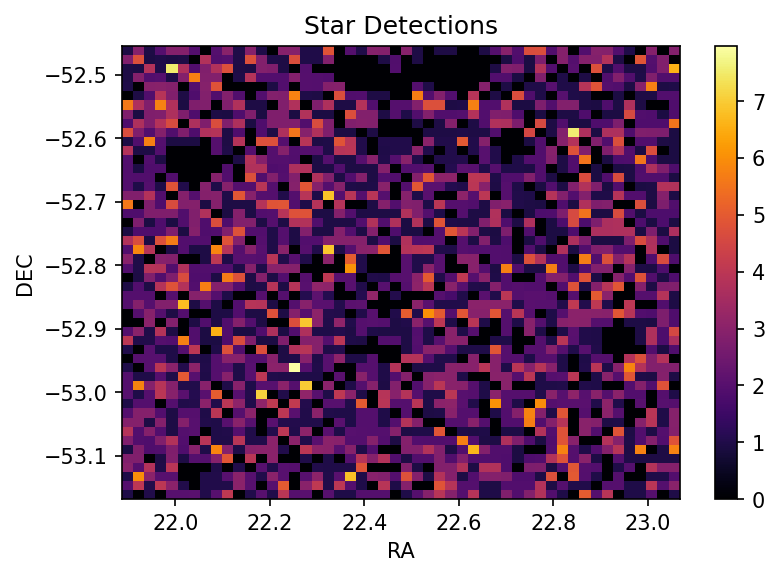

In [20]:
plt.figure(dpi = 150)
hCorr = plt.hist2d(realRA, realDEC, weights = realDET.astype('float'), bins = 50, cmap = 'inferno')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Star Detections')
plt.colorbar()
plt.show()

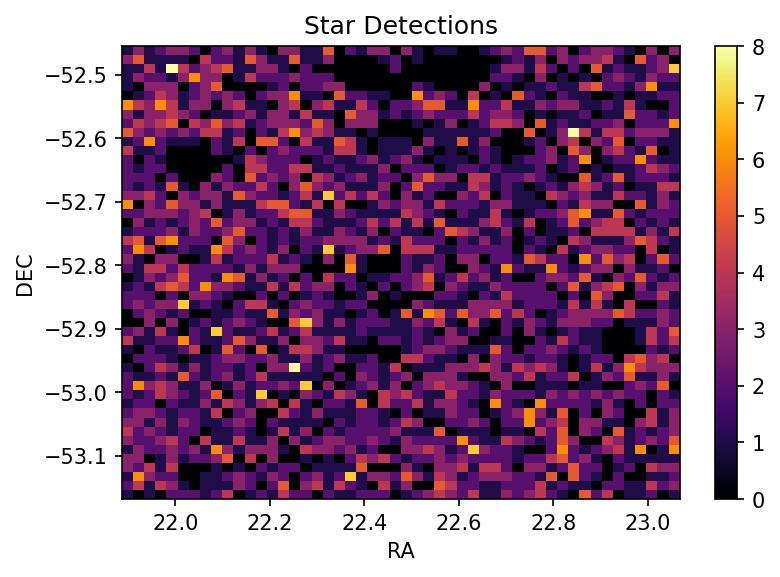

In [21]:
plt.figure(dpi = 150)
hOrig = plt.hist2d(realRA, realDEC, bins = 50, cmap = 'inferno')
plt.xlabel('RA')
plt.ylabel('DEC')
plt.title('Star Detections')
plt.colorbar()
plt.show()

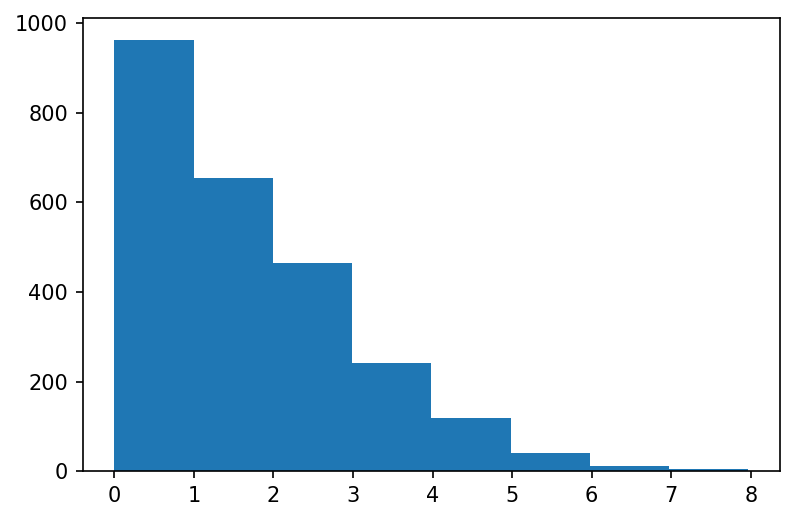

In [22]:
corrDist = hCorr[0].flatten()
plt.figure(dpi = 150)
plt.hist(corrDist, bins = 8)
plt.show()

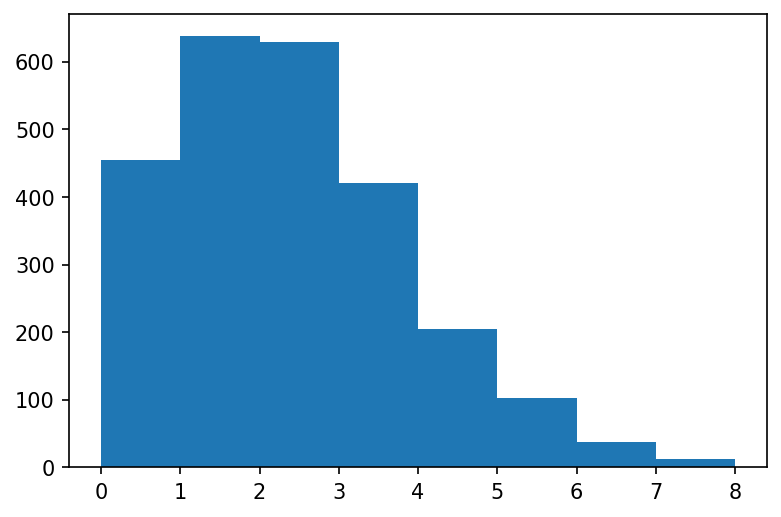

In [23]:
origDist = hOrig[0].flatten()
plt.figure(dpi = 150)
plt.hist(origDist, bins = 8)
plt.show()

In [24]:
print(np.std(corrDist))
print(np.std(origDist))

1.434591922525209
1.4908984673679155


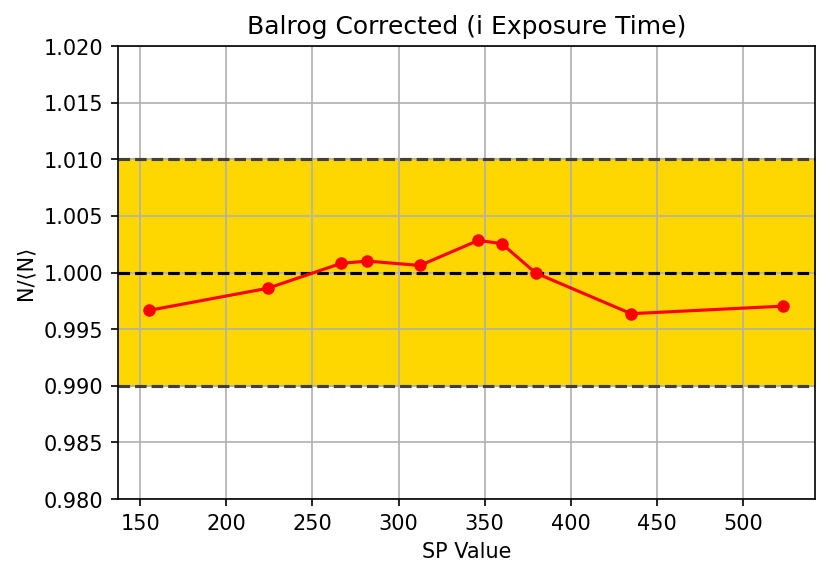

In [25]:
oneMap = balrCondMaps[Config.exptimeSUMi]

numBinsTest = 10
binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = balrDET[sortInds[::1]]
injStarTemp = balrINJ[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
#plt.fill_between(plt.gca().get_xlim(), 0.98, 1.02, color = (176/256,141/256,87/256))
#plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = (192/256,192/256,192/256))
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.ylim([0.98, 1.02])
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Balrog Corrected (i Exposure Time)')
plt.grid(zorder = 0)
plt.show()

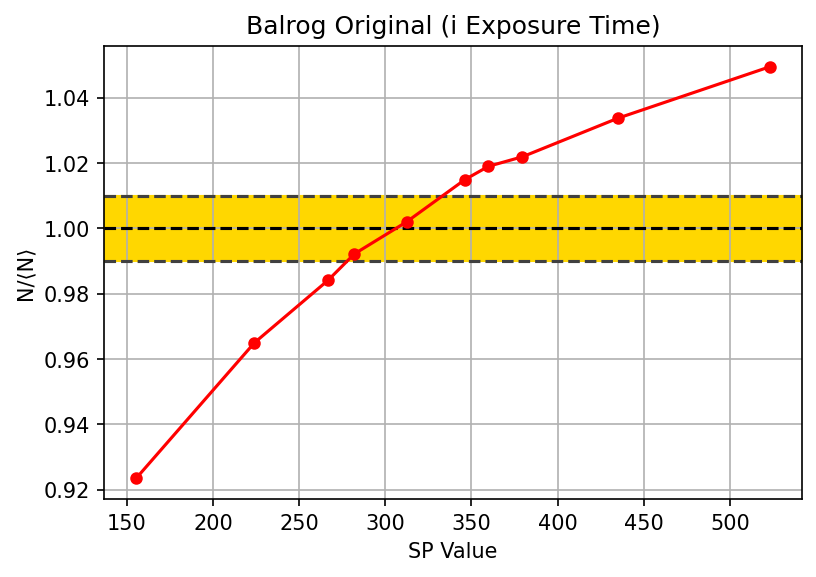

In [26]:
oneMap = balrCondMaps[Config.exptimeSUMi]

binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = originalBalrDET[sortInds[::1]]
injStarTemp = balrINJ[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
# plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'silver')
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Balrog Original (i Exposure Time)')
plt.grid(zorder = 0)
plt.show()